In [4]:
import sys
sys.path.insert(1, '../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime, concat
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
    series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
    PersistenceOptimistRegressor, PersistenceRealistRegressor, scale_all_dataframe, \
    exponential_smoothing_study, rolling_mean_study, arima_study, DS_LSTM,lstm_study, prepare_dataset_for_lstm, arima_study_inflation, \
    DS_LSTM_Inflation, prepare_dataset_for_lstm_inflation, lstm_study_inflation
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

**Loading in Data**

(Date
 2011-01-01    0.197484
 2012-01-01    0.261964
 2013-01-01    1.000000
 2014-01-01    0.716740
 2015-01-01    0.130821
 Name: Inflation Rate (%), dtype: float64,
 Date
 2020-01-01    0.638355
 2021-01-01   -0.611511
 2022-01-01    0.451519
 2023-01-01    0.379577
 Name: Inflation Rate (%), dtype: float64)

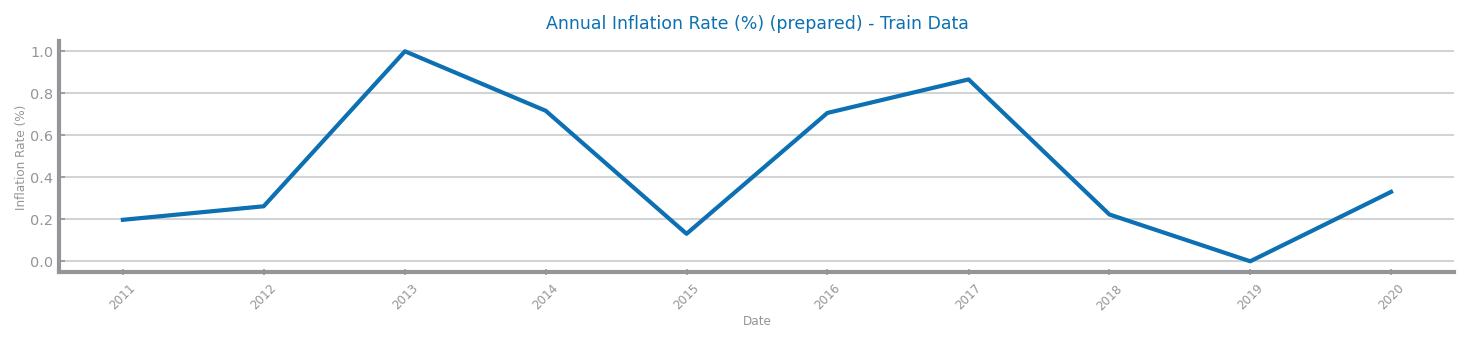

In [5]:
target = "Inflation Rate (%)"
chart_target = "Inflation"
file_tag = "inflation"
timecol = "Date"

train_path = "../data/prepared/scaling/inflation_train_scaling.csv"
test_path  = "../data/prepared/scaling/inflation_test_scaling.csv"

train_df = read_csv(train_path, parse_dates=["Date"], index_col="Date")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Date"], index_col="Date")
test: Series = test_df[target]
test.index = to_datetime(test.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"Annual {target} (prepared) - Train Data",
)

train.head(), test.head()

## Exponential Smoothing

## Multi-Layer Perceptrons

Inspiration: https://github.com/zakarm/MLP-TimeSeries-Forecaster/blob/main/MLP.ipynb

In [108]:
from matplotlib import pyplot as plt

In [109]:
# Concatinate train and test for MLP study, and convert to dataframe
df: DataFrame = DataFrame()
df[target] = concat([train, test])

k = 3 # number of lagged observations
Z = []

for i in range(k + 1, df.shape[0] + 1):Z.append(df.iloc[(i - k - 1): i, 0])

Z = np.array(Z)

print("Shape of supervised data:", Z.shape)
print(Z)

Shape of supervised data: (11, 4)
[[ 0.1974838   0.26196356  1.          0.71674004]
 [ 0.26196356  1.          0.71674004  0.13082072]
 [ 1.          0.71674004  0.13082072  0.70636028]
 [ 0.71674004  0.13082072  0.70636028  0.86599377]
 [ 0.13082072  0.70636028  0.86599377  0.22280683]
 [ 0.70636028  0.86599377  0.22280683  0.        ]
 [ 0.86599377  0.22280683  0.          0.33050574]
 [ 0.22280683  0.          0.33050574  0.63835499]
 [ 0.          0.33050574  0.63835499 -0.61151079]
 [ 0.33050574  0.63835499 -0.61151079  0.45151938]
 [ 0.63835499 -0.61151079  0.45151938  0.37957694]]


In [110]:
# Split into train and test
split = int(0.75 * Z.shape[0])
print(split)
Z_train, Z_test = Z[:split, :], Z[split:, :]

8


In [111]:
# Split into X and y
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (8, 3)
y_train shape: (8,)


In [112]:
# Define functions to compute losses
def MSE_loss(hidden_neurons):

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=1000, random_state=1)

    mlp.fit(X_train, y_train)
    
    return mean_squared_error(y_test, mlp.predict(X_test))

def MAE_loss(hidden_neurons):

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=1000, random_state=1)

    mlp.fit(X_train, y_train)
    
    return mean_absolute_error(y_test, mlp.predict(X_test))

def R2_loss(hidden_neurons):

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=1000, random_state=1)

    mlp.fit(X_train, y_train)
    
    return r2_score(y_test, mlp.predict(X_test))

In [ ]:
# Compute losses for different hidden layer sizes
params = [i for i in range(5, 200 + 5, 5)]
mse = [MSE_loss(p) for p in params]
mae = [MAE_loss(p) for p in params]
r2 = [R2_loss(p) for p in params]

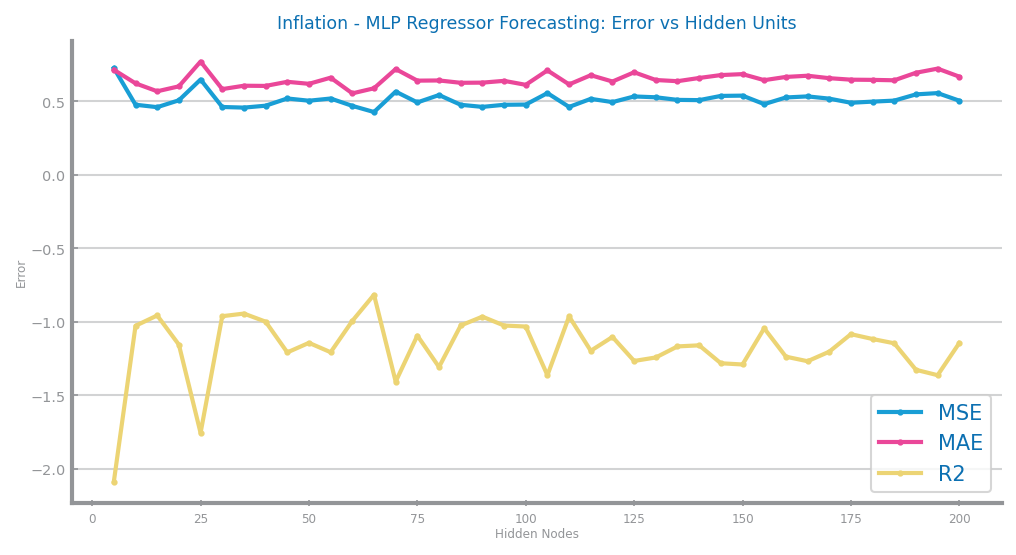

In [113]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
plt.title(f'{chart_target} - MLP Regressor Forecasting: Error vs Hidden Units')
plt.xlabel('Hidden Nodes')
plt.ylabel('Error')
plt.plot(params, mse, '-o')
plt.plot(params, mae, '-o')
plt.plot(params, r2, '-o')
plt.legend(['MSE', 'MAE', 'R2'])
plt.show()

In [114]:
params[np.argmax(r2)]

65

In [118]:
mlp = MLPRegressor(hidden_layer_sizes=(65,), max_iter=1000, random_state=1)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

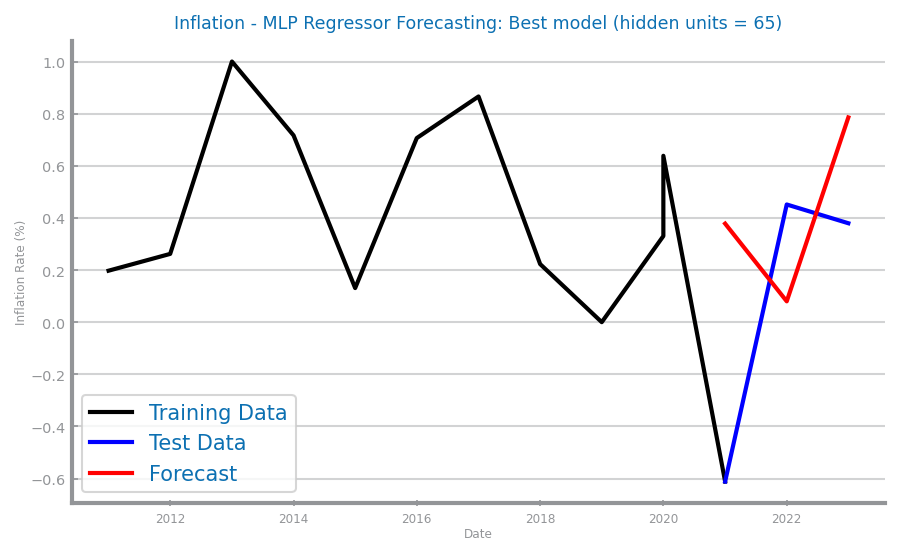

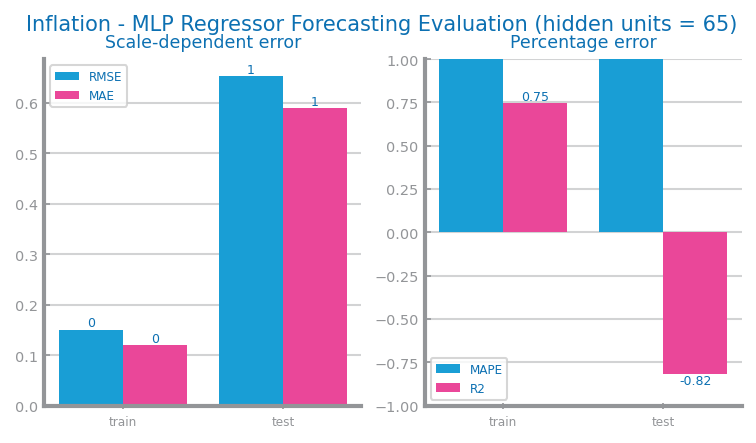

In [119]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'{chart_target} - MLP Regressor Forecasting: Best model (hidden units = 65)')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred, index=df.index[-len(y_test):]), color='red', label='Forecast')
legend()
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

plot_forecasting_eval(
    pd.Series(y_train, index=df.index[k:k + len(y_train)]),
    pd.Series(y_test, index=df.index[-len(y_test):]),
    pd.Series(mlp.predict(X_train), index=df.index[k:k + len(y_train)]),
    pd.Series(y_pred, index=df.index[-len(y_test):]),
    title=f"{chart_target} - MLP Regressor Forecasting Evaluation (hidden units = 65)",
)

## ARIMA

                               SARIMAX Results                                
Dep. Variable:     Inflation Rate (%)   No. Observations:                   10
Model:                 ARIMA(3, 1, 2)   Log Likelihood                   1.851
Date:                Wed, 17 Dec 2025   AIC                              8.299
Time:                        12:32:34   BIC                              9.482
Sample:                    01-01-2011   HQIC                             5.745
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4715      0.656      0.718      0.473      -0.815       1.758
ar.L2         -0.7092      0.319     -2.220      0.026      -1.335      -0.083
ar.L3          0.7934      0.663      1.197      0.2

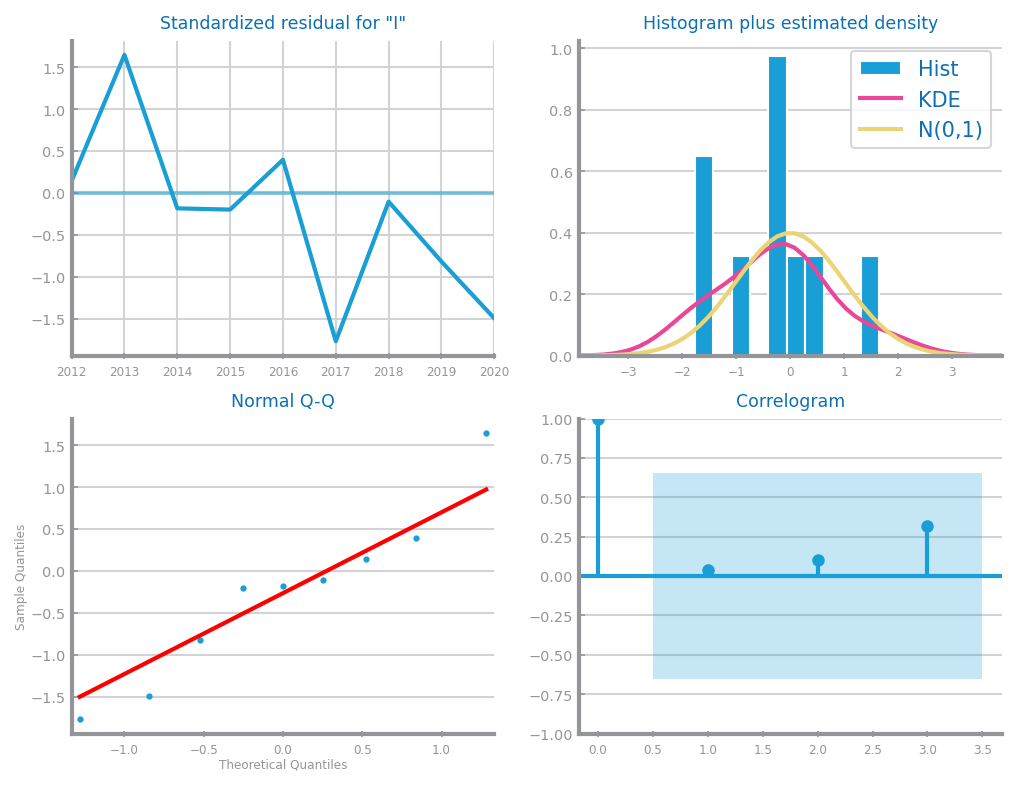

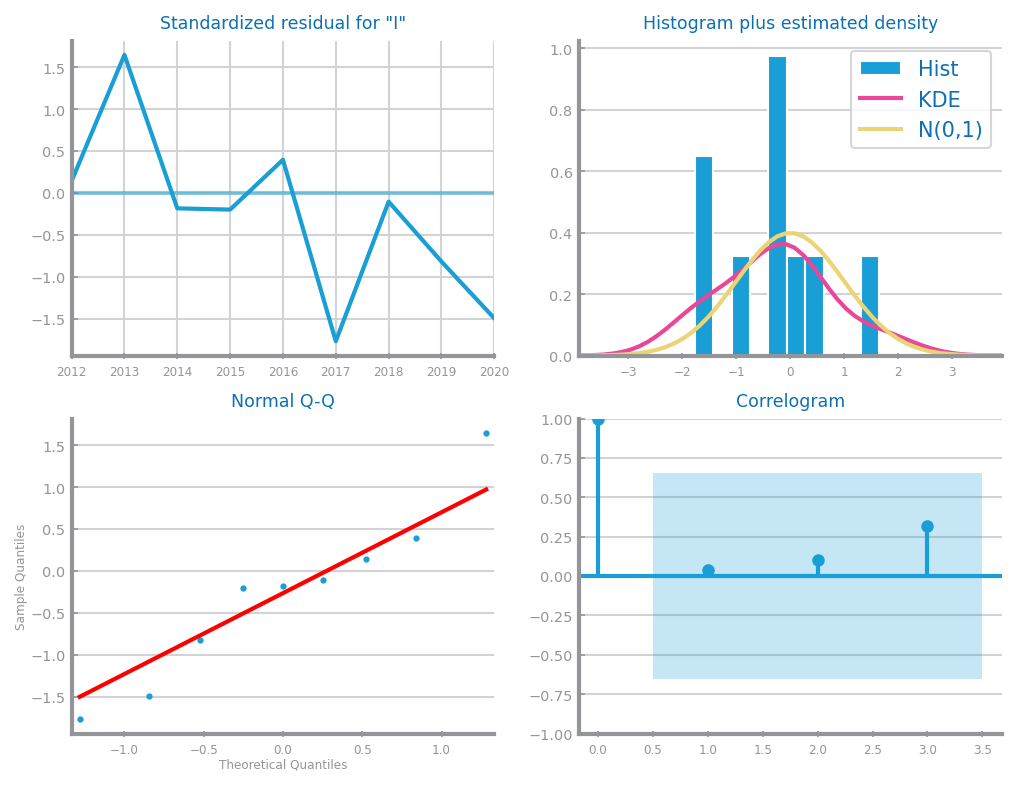

In [4]:
predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

model.plot_diagnostics(lags=3, figsize=(2 * HEIGHT, 1.5 * HEIGHT))

ARIMA best results achieved with (p,d,q)=(5.0, 0.0, 2.0) ==> measure=0.353471


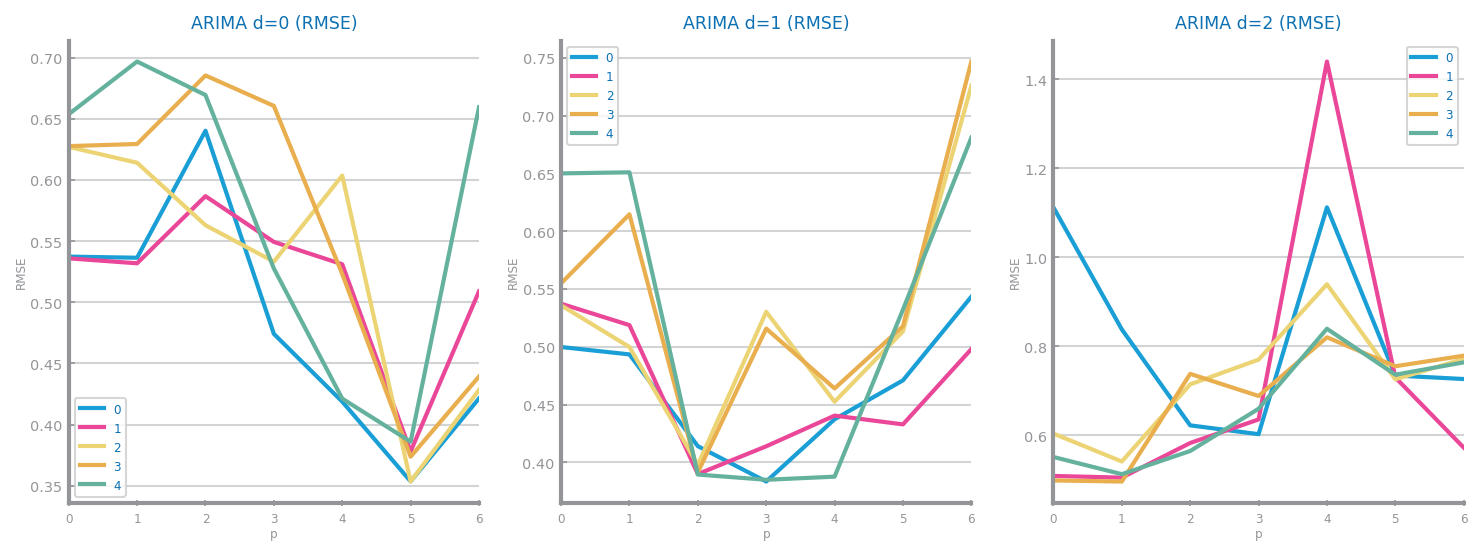

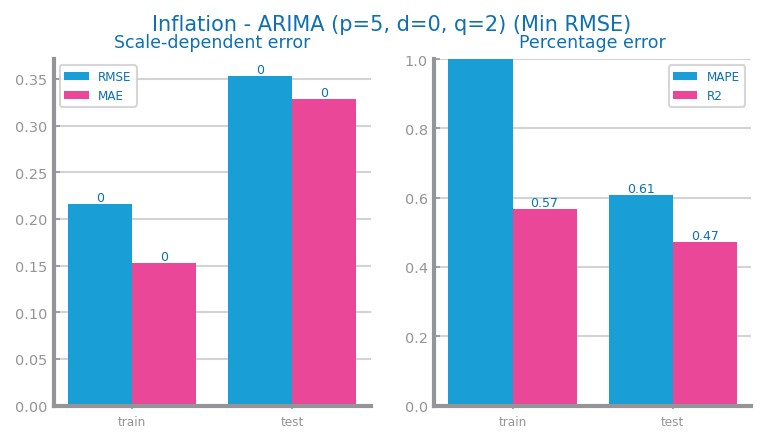

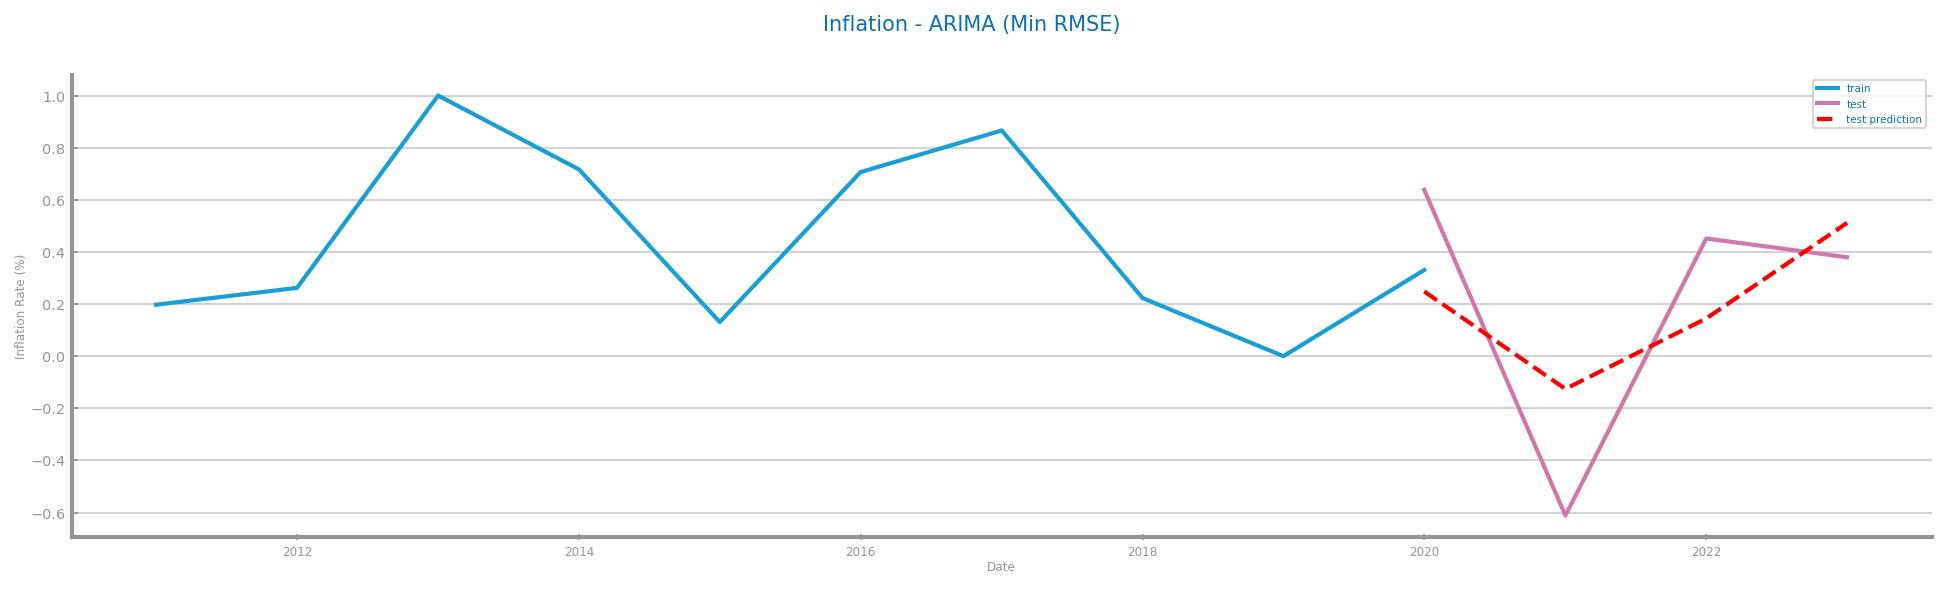

ARIMA best results achieved with (p,d,q)=(1.0, 1.0, 1.0) ==> measure=0.317161


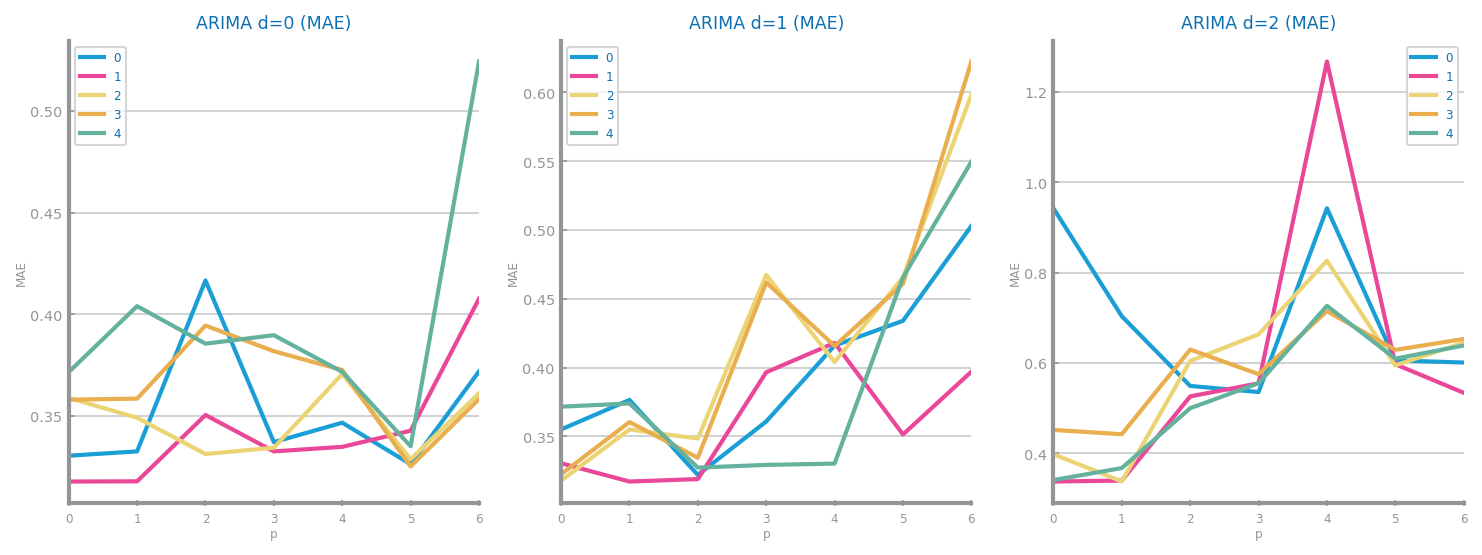

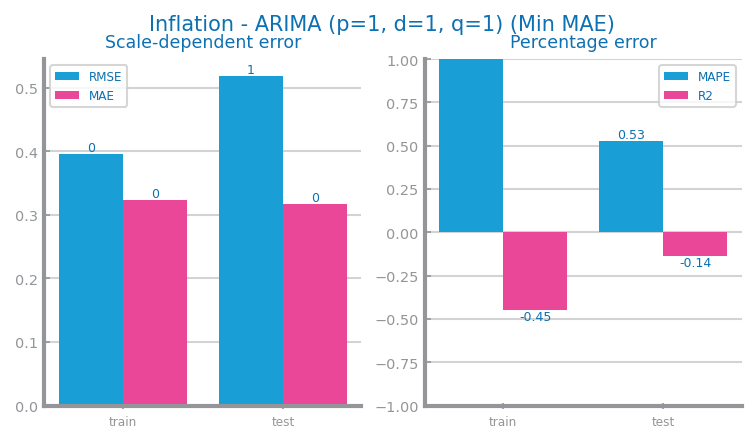

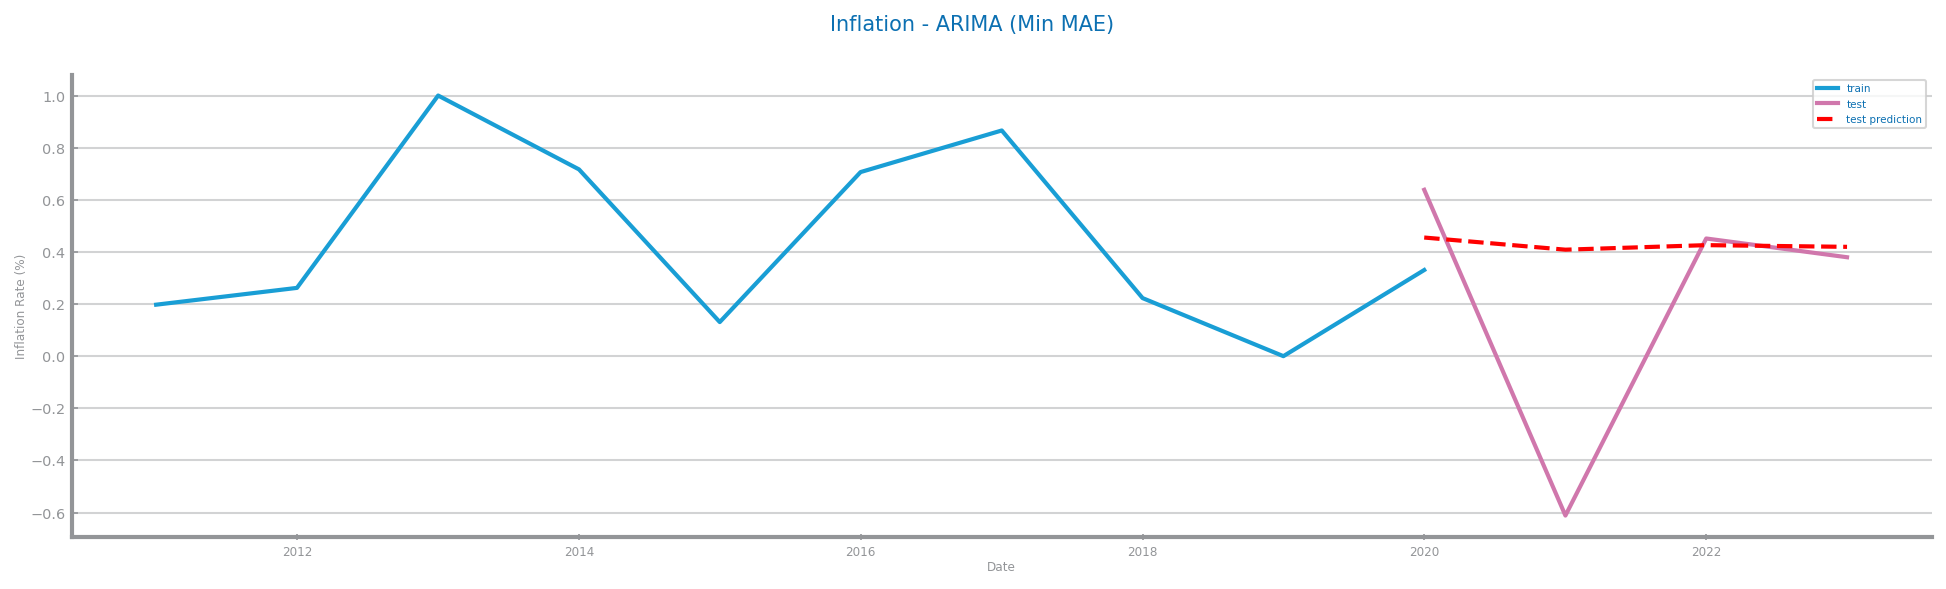

In [5]:
measures = ["RMSE", "MAE"]
for measure in measures:
    best_model, best_params = arima_study_inflation(train, test, measure=measure)
    savefig(f"../charts/forecasting/{file_tag}_arima_{measure}_study.png")
    show()

    params = best_params["params"]
    prd_trn = best_model.predict(start=0, end=len(train) - 1)
    prd_tst = best_model.forecast(steps=len(test))
    prd_tst.index = test.index

    plot_forecasting_eval(
        train, test, prd_trn, prd_tst, title=f"{chart_target} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]}) (Min {measure})"
    )
    savefig(f"../charts/forecasting/{file_tag}_arima_{measure}_eval.png")
    show()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{chart_target} - ARIMA (Min {measure})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_arima_{measure}_forecast.png")
    show()

## LSTM

In [6]:
train_lstm = train.astype("float32")
test_lstm = test.astype("float32")

model = DS_LSTM_Inflation(train_lstm, input_size=1, hidden_size=50, num_layers=1, length=4)
loss = model.fit()
print(loss)

tensor(0.5743, grad_fn=<MseLossBackward0>)


seq length=1 hidden_units=25 nr_episodes=0 0.4997399151325226
seq length=1 hidden_units=25 nr_episodes=300 0.6371201276779175
seq length=1 hidden_units=25 nr_episodes=600 0.6348122954368591
seq length=1 hidden_units=25 nr_episodes=900 0.6387952566146851
seq length=1 hidden_units=25 nr_episodes=1200 0.6389364004135132
seq length=1 hidden_units=25 nr_episodes=1500 0.6404867172241211
seq length=1 hidden_units=25 nr_episodes=1800 0.6413705348968506
seq length=1 hidden_units=25 nr_episodes=2100 0.6410045027732849
seq length=1 hidden_units=25 nr_episodes=2400 0.642085075378418
seq length=1 hidden_units=25 nr_episodes=2700 0.6378406286239624
seq length=1 hidden_units=25 nr_episodes=3000 0.6342929005622864
seq length=1 hidden_units=50 nr_episodes=0 0.5218979716300964
seq length=1 hidden_units=50 nr_episodes=300 0.6326348185539246
seq length=1 hidden_units=50 nr_episodes=600 0.633678674697876
seq length=1 hidden_units=50 nr_episodes=900 0.6354103684425354
seq length=1 hidden_units=50 nr_episode

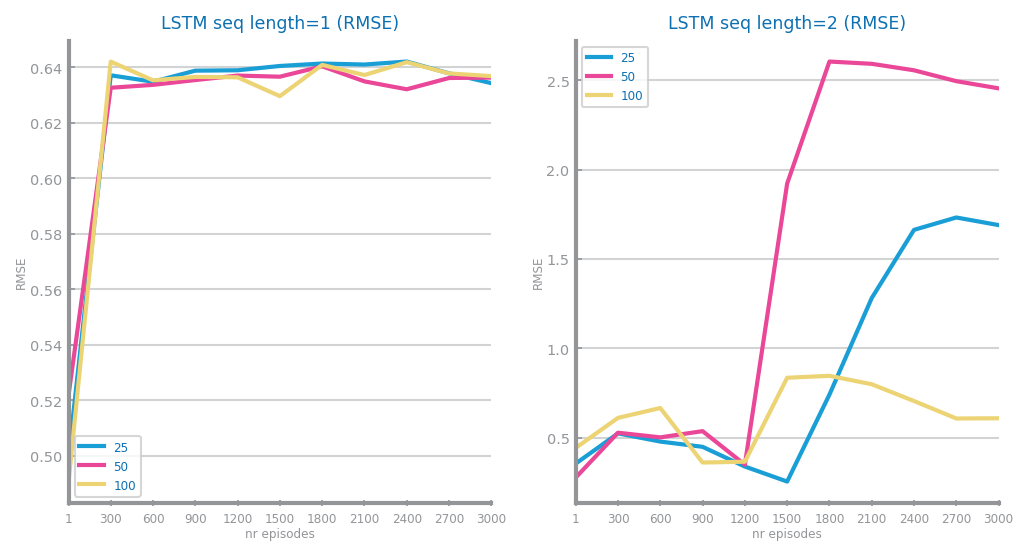

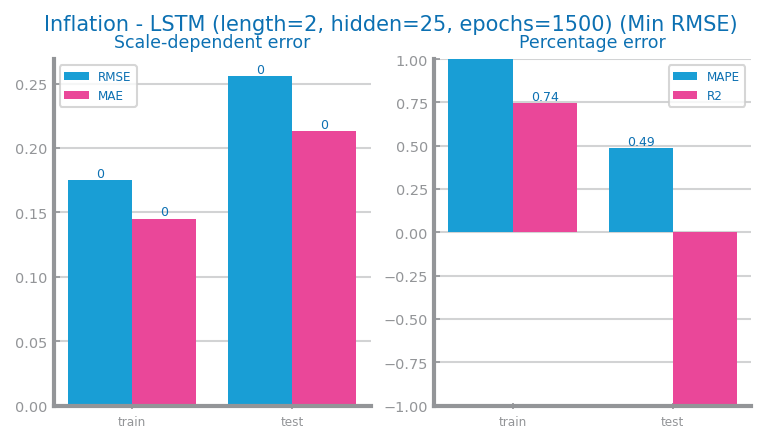

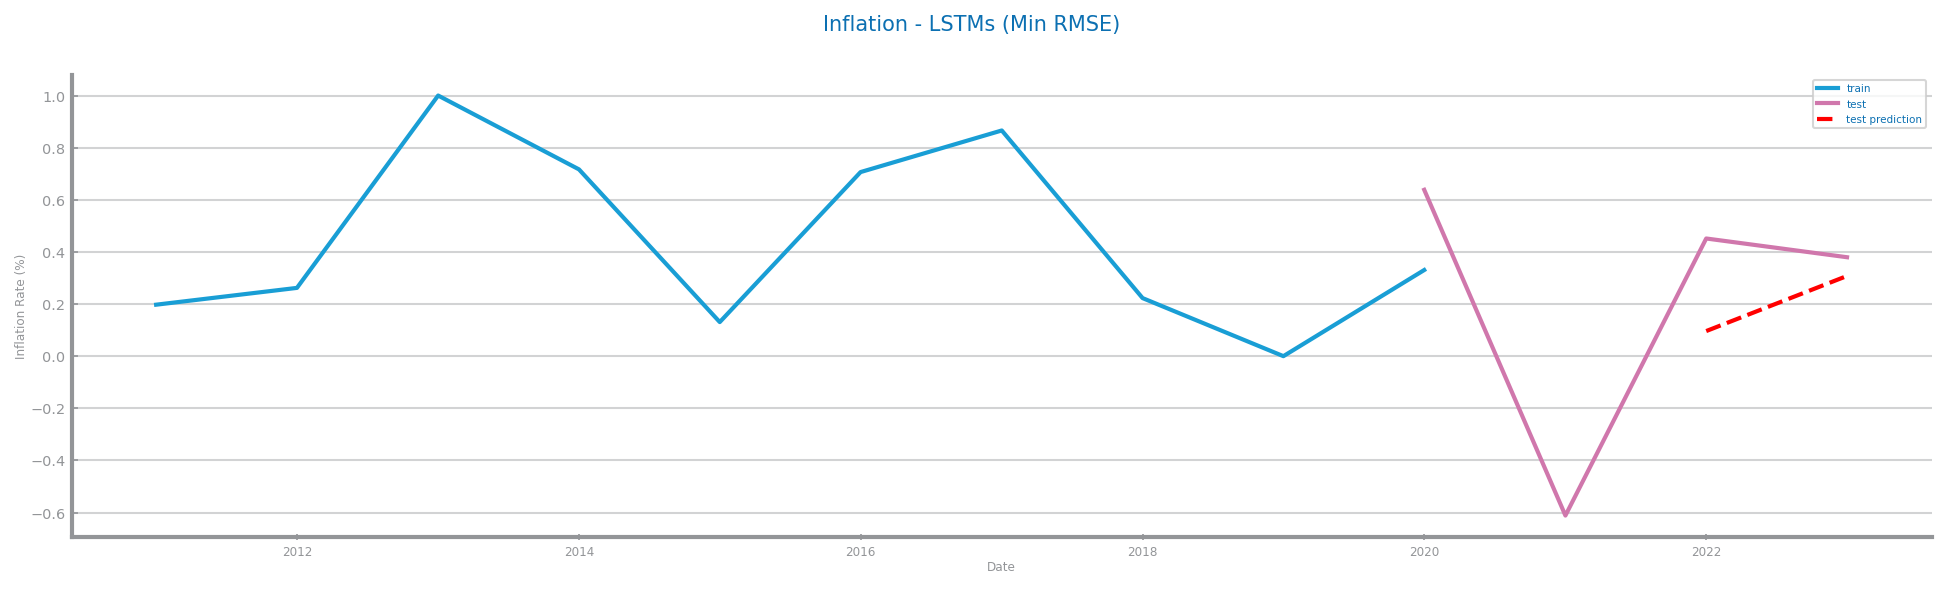

seq length=1 hidden_units=25 nr_episodes=0 0.4294898808002472
seq length=1 hidden_units=25 nr_episodes=300 0.4200689494609833
seq length=1 hidden_units=25 nr_episodes=600 0.4197108745574951
seq length=1 hidden_units=25 nr_episodes=900 0.4190104901790619
seq length=1 hidden_units=25 nr_episodes=1200 0.4196213185787201
seq length=1 hidden_units=25 nr_episodes=1500 0.420807808637619
seq length=1 hidden_units=25 nr_episodes=1800 0.41973212361335754
seq length=1 hidden_units=25 nr_episodes=2100 0.419249027967453
seq length=1 hidden_units=25 nr_episodes=2400 0.4202936589717865
seq length=1 hidden_units=25 nr_episodes=2700 0.41853365302085876
seq length=1 hidden_units=25 nr_episodes=3000 0.4216822683811188
seq length=1 hidden_units=50 nr_episodes=0 0.4770573079586029
seq length=1 hidden_units=50 nr_episodes=300 0.41608956456184387
seq length=1 hidden_units=50 nr_episodes=600 0.4200521409511566
seq length=1 hidden_units=50 nr_episodes=900 0.41863515973091125
seq length=1 hidden_units=50 nr_epi

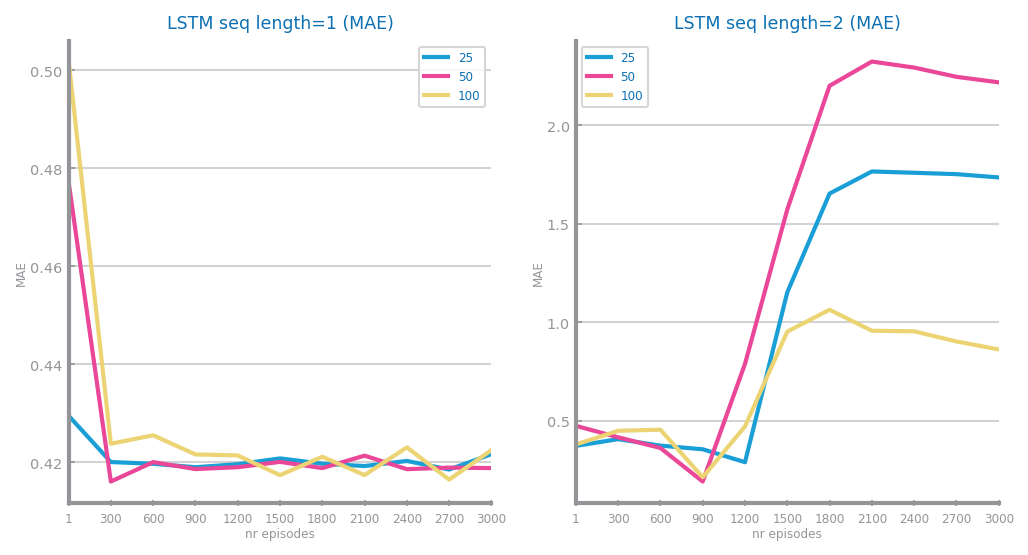

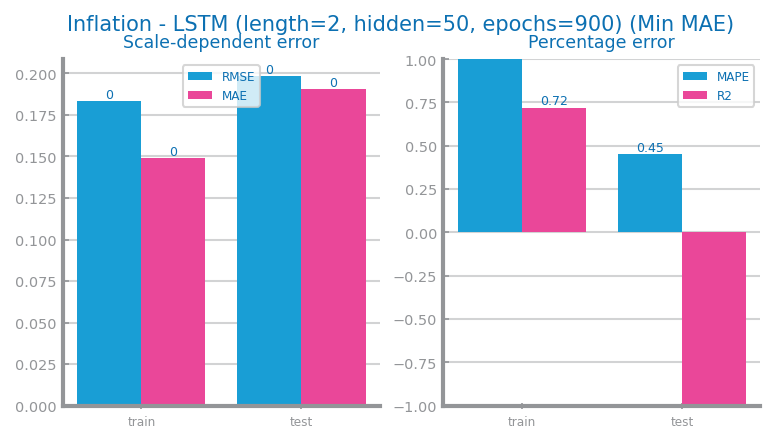

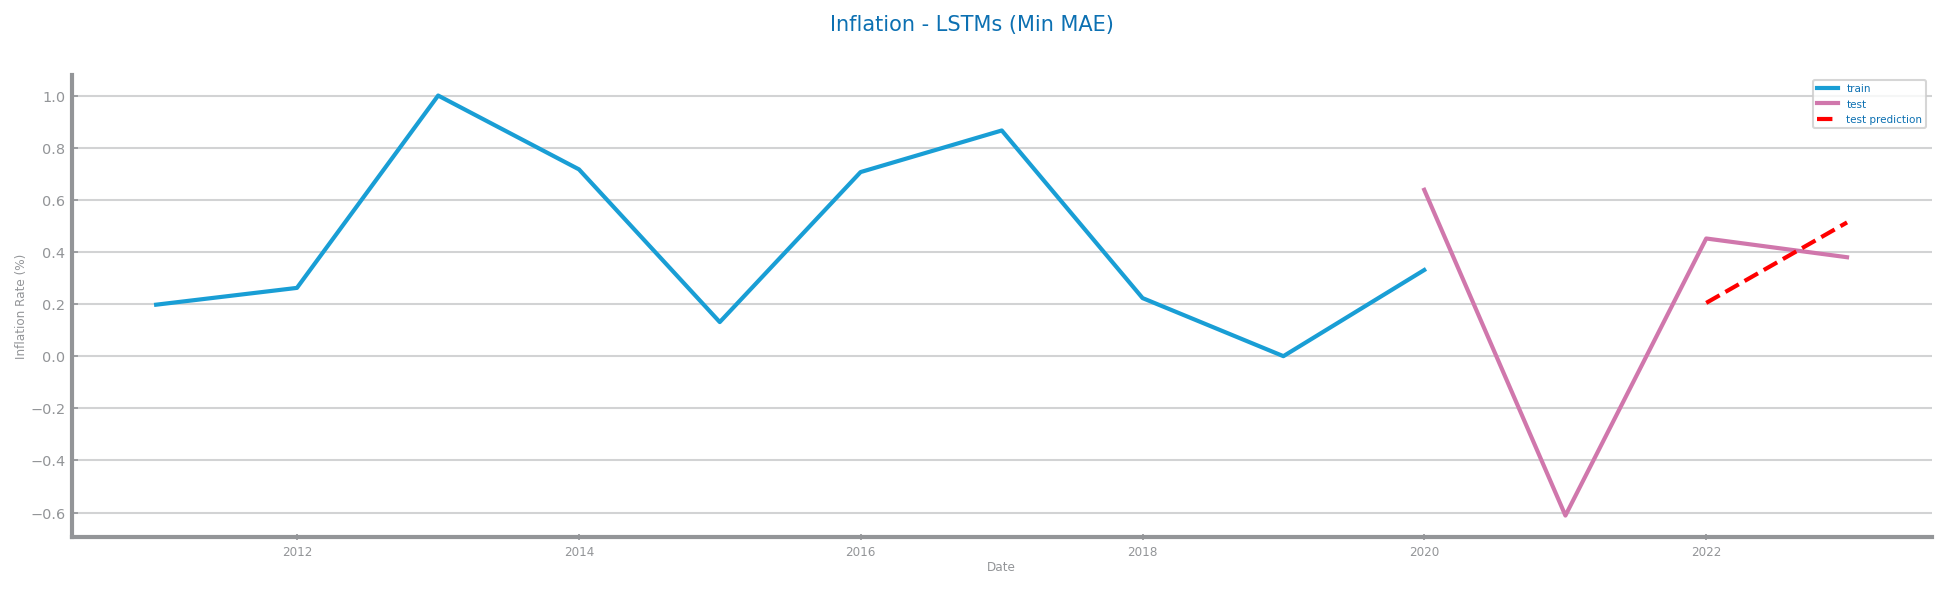

In [9]:
measures = ["RMSE", "MAE"]
for measure in measures:
    best_model, best_params = lstm_study_inflation(train_lstm, test_lstm, nr_episodes=3000, measure=measure)
    savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_study.png")
    show()

    params = best_params["params"]
    best_length = params[0]
    trnX, trnY = prepare_dataset_for_lstm_inflation(train_lstm, seq_length=best_length)
    tstX, tstY = prepare_dataset_for_lstm_inflation(test_lstm, seq_length=best_length)

    prd_trn = best_model.predict(trnX).detach().cpu().numpy().ravel()
    prd_tst = best_model.predict(tstX).detach().cpu().numpy().ravel()

    plot_forecasting_eval(
        train_lstm[best_length:],
        test_lstm[best_length:],
        prd_trn,
        prd_tst,
        title=f"{chart_target} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]}) (Min {measure})",
    )
    savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_eval.png")
    show()

    pred_full = np.full(len(test), np.nan, dtype=float)
    pred_full[best_length:] = prd_tst

    pred_series = Series(pred_full, index=test.index)

    plot_forecasting_series(
        train,
        test,
        pred_series,
        title=f"{chart_target} - LSTMs (Min {measure})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_forecast.png")
    show()

**Note on Sequence Length:** Because the dataset is small [len(train=10), len(test=10)], only sequence lengths 1 and 2 provide enough test windows for meaningful eval. We didn't go up to sequence length of 3 because it produces only one test forecase which is unstable and unreliable.